In [18]:
!pip install numpy pandas tensorflow keras librosa matplotlib

In [16]:
import librosa
import numpy as np

def extract_spectrogram(file_path, max_pad_len=174):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        
        # Extract MFCC features from the audio
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # If MFCCs length is smaller than max_pad_len, pad it with zeros
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        # If MFCCs length is longer, truncate to the fixed length
        else:
            mfccs = mfccs[:, :max_pad_len]
        
        return mfccs
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}. Error: {str(e)}")
        return None



In [3]:
import os

def load_data(data_dir):
    labels = []
    features = []  # class names like 'dog', 'cat', etc.
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(class_name)
                    
    return np.array(features), np.array(labels)

data_dir = "C:\\Users\\Vimal MR\\Documents\\Animal Sound Classification - Final Year Project\\data"  # Folder where all your sound folders are
X, y = load_data(data_dir)


In [18]:
def load_dataset(folder_path, class_labels):
    data = []
    labels = []
    
    for i, label in enumerate(class_labels):
        files = os.listdir(os.path.join(folder_path, label))
        
        for file in files:
            audio_path = os.path.join(folder_path, label, file)
            spect = extract_spectrogram(audio_path)
            data.append(spect)
            labels.append(i)  # Label encoding as integers
            
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

# Load your data
class_labels = ['Dog', 'Cat']  
data, labels = load_dataset('C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data', class_labels)


In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train = X_train[..., np.newaxis]  # Reshape for RNN (samples, time_steps, features)
X_test = X_test[..., np.newaxis]

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

C:\Users\Vimal MR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 40, 128)             │         155,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,834 (815.76 KB)

 Trainable params: 208,834 (815.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.5314 - loss: 0.6934 - val_accuracy: 0.5500 - val_loss: 0.6871
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7356 - loss: 0.5955 - val_accuracy: 0.5750 - val_loss: 0.6587
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8745 - loss: 0.4952 - val_accuracy: 0.6625 - val_loss: 0.5932
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9676 - loss: 0.2916 - val_accuracy: 0.6875 - val_loss: 0.7107
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9781 - loss: 0.1133 - val_accuracy: 0.6625 - val_loss: 0.8970
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9858 - loss: 0.0432 - val_accuracy: 0.7000 - val_loss: 0.8395
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9991 - loss: 0.0113 - val_accuracy: 0.6750 - val_loss: 0.9268
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.7250 - 

In [22]:
# Predict labels for the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=0)

# Compare predicted labels to true labels
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
Accuracy: 46.25%


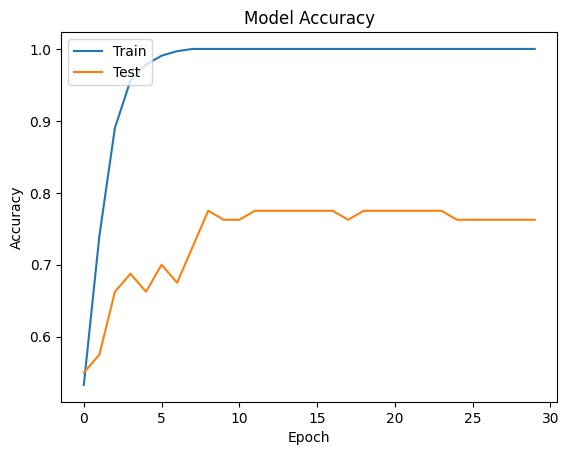

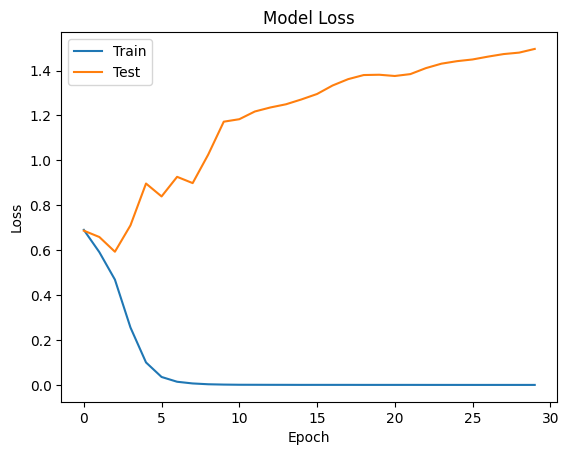

In [24]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [25]:
def predict_animal(file_path):
    # Extract features and ensure the audio is processed the same way as during training
    feature = extract_features(file_path, max_pad_len=174)  # Use the same max_pad_len as training
    if feature is None:
        print("Could not extract features from the audio file.")
        return None
    
    # Reshape the feature to match the input shape expected by the model
    feature = feature[np.newaxis, ..., np.newaxis]  # Shape: (1, time_steps, features, 1)
    
    # Predict
    prediction = model.predict(feature)
    
    # Convert prediction to class label
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_class[0]


# Test on a new sound file
file_path = 'C:/Users/Vimal MR/Documents/Animal Sound Classification - Final Year Project/data/baba.wav'
predicted_animal = predict_animal(file_path)
print(f"Predicted animal: {predicted_animal}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted animal: Cat


In [26]:
from sklearn.metrics import classification_report

# Step 1: Get predictions for the test set
y_pred = model.predict(X_test)

# Step 2: Convert predicted probabilities to class labels
# If your output is one-hot encoded or uses softmax, pick the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

         Cat       0.81      0.76      0.79        46
         Dog       0.70      0.76      0.73        34

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.77      0.76      0.76        80

